# Assignment 9: Autoencoder


### Build an autoencoder for the Kaggle MNIST training dataset.

Import and preprocess data
Set parameters and define autoencoder backpropagation function
Run a process to train autoencoder
Visualise what the autoencoder has learned
Take the output of that autoencoder and use it to classify the MNIST test set observations.  Submit your results to Kaggle.com.

# Discussion 

Although not part of the prompt, I thought it necessary to add a few discussion points. It seems that both autoencoders perform quite well and are discernable. 

## Testing

In [1]:
# import base packages into the namespace for this program
import os
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime

#diplay and plotting
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from keras import layers

import pydot
import graphviz
import getpass
import smtplib

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.manifold import TSNE



In [2]:
# read data for the Boston Housing Study
Digit_input = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/Digits-Train.csv")
Digit_test = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/test.csv")
#sets random seed for entire notebook
RANDOM_SEED = 13


In [3]:
Digit_input.label.value_counts().sort_values()

5    3795
8    4063
4    4072
0    4132
6    4137
2    4177
9    4188
3    4351
7    4401
1    4684
Name: label, dtype: int64

## Build our tensorboard log function

In [4]:
logdir = 'C:/Users/bblank/Documents/keras_logfiles'
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join('C:/Users/bblank/Documents/keras_logfiles', run_id)

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

## Split our data train and validation holdout

In [5]:
#splits into validation and train.
train, val =  train_test_split(Digit_input, test_size = 0.3, random_state = RANDOM_SEED)
val, test = train_test_split(val, test_size =0.3 , random_state =RANDOM_SEED)

y_train = train.label.copy()
X_train = train.drop('label', axis=1)

y_val = val.label.copy()
X_val = val.drop('label', axis=1)

y_test = test.label.copy()
X_test = test.drop('label', axis=1)

## Quick image EDA

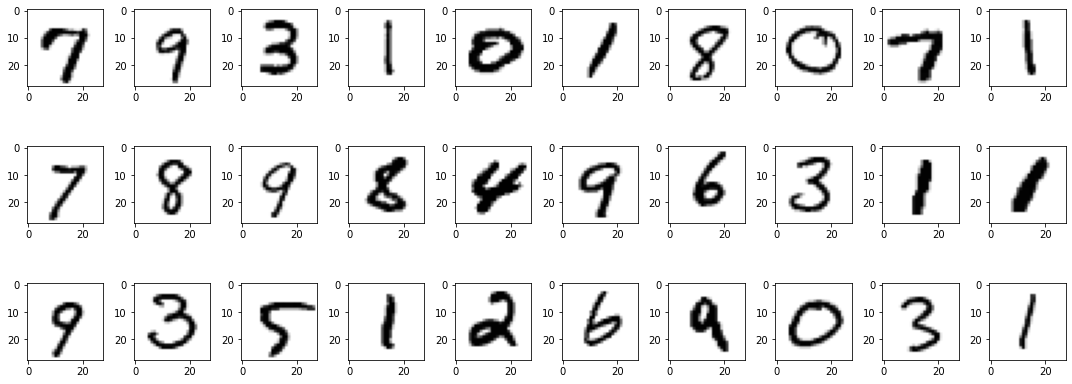

In [6]:
## plots the first 30 digits in 3 rows of 10 images. Data is unscaled
num_row = 3
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(30):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(X_train.iloc[i]).reshape(28,28), cmap='gist_yarg')
    #ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [7]:


X_train = X_train.astype('float32')/255.
X_val = X_val.astype('float32')/255.



In [8]:
scale = Pipeline([
        ('scaler', MinMaxScaler())
        ])
X_train = scale.fit_transform(X_train)
x_val = scale.fit_transform(X_val)
x_test = scale.fit_transform(X_test)

In [9]:
X_train = np.asarray(X_train)
X_val= np.asarray(X_val)
X_train = X_train.reshape((len(X_train), 28,28,1))
X_val = X_val.reshape((len(X_val), 28,28,1))

X_train.shape

(29400, 28, 28, 1)

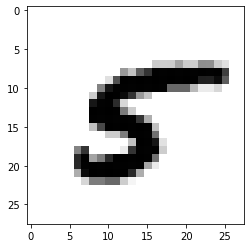

In [10]:
plt.imshow(X_val[1], cmap='gist_yarg')

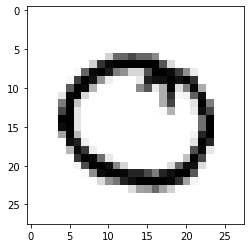

In [11]:
plt.imshow(X_train[7], cmap='gist_yarg')

In [12]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

optimizer = keras.optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

In [13]:
before_fit = datetime.now()
Convo_history= autoencoder.fit(X_train, X_train, epochs=10, batch_size=128, shuffle=True,
                validation_data=(X_val, X_val))


after_fit = datetime.now()


elapsed =after_fit - before_fit
convo_duration = elapsed.total_seconds()

Epoch 1/10
230/230 [==============================] - 28s 121ms/step - loss: 0.3993 - val_loss: 0.1749
Epoch 2/10
230/230 [==============================] - 27s 118ms/step - loss: 0.1666 - val_loss: 0.1503
Epoch 3/10
230/230 [==============================] - 26s 113ms/step - loss: 0.1468 - val_loss: 0.1379
Epoch 4/10
230/230 [==============================] - 28s 120ms/step - loss: 0.1360 - val_loss: 0.1312
Epoch 5/10
230/230 [==============================] - 25s 110ms/step - loss: 0.1291 - val_loss: 0.1252
Epoch 6/10
230/230 [==============================] - 25s 107ms/step - loss: 0.1240 - val_loss: 0.1212
Epoch 7/10
230/230 [==============================] - 25s 107ms/step - loss: 0.1207 - val_loss: 0.1182
Epoch 8/10
230/230 [==============================] - 25s 109ms/step - loss: 0.1175 - val_loss: 0.1159
Epoch 9/10
230/230 [==============================] - 26s 112ms/step - loss: 0.1153 - val_loss: 0.1142
Epoch 10/10
230/230 [==============================] - 26s 114ms/step - l

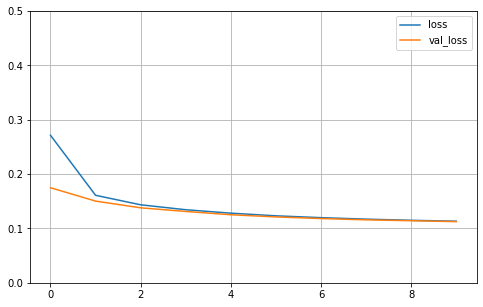

In [14]:
pd.DataFrame(Convo_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.5)
plt.show()

In [15]:
X_test = X_test.astype('float32')/255.
X_test= np.asarray(X_test)
X_test = X_test.reshape((len(X_test), 28,28,1))

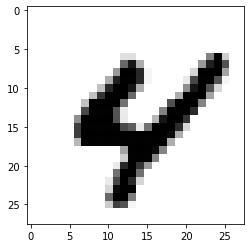

In [16]:
plt.imshow(X_test[12], cmap='gist_yarg')

In [17]:
preds = autoencoder.predict(X_test)


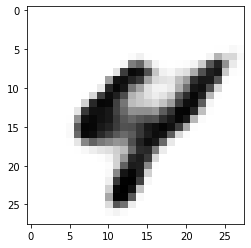

In [18]:
plt.imshow(preds[12], cmap='gist_yarg')

In [58]:
# saves the autoencoder weights

autoencoder.save_weights('autoencoder.h5')

In [19]:

X_train = X_train.reshape((len(X_train), 28,28))
X_val = X_val.reshape((len(X_val), 28,28))
X_test = np.asarray(X_test)
X_test = X_test.reshape((len(X_test), 28,28))

In [20]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation= 'selu')
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape=([30])),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

stacked_auto = keras.models.Sequential([stacked_encoder,stacked_decoder])
stacked_auto.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5))

In [21]:
before_fit = datetime.now()
stacked_history= stacked_auto.fit(X_train, X_train, epochs=10, validation_data=(X_val, X_val))
after_fit = datetime.now()


elapsed =after_fit - before_fit
stacked_duration = elapsed.total_seconds()

Epoch 1/10
919/919 [==============================] - 3s 3ms/step - loss: 0.2610 - val_loss: 0.1608
Epoch 2/10
919/919 [==============================] - 2s 3ms/step - loss: 0.1505 - val_loss: 0.1342
Epoch 3/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1305 - val_loss: 0.1243
Epoch 4/10
919/919 [==============================] - 2s 3ms/step - loss: 0.1220 - val_loss: 0.1168
Epoch 5/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1162 - val_loss: 0.1140
Epoch 6/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1129 - val_loss: 0.1136
Epoch 7/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1104 - val_loss: 0.1098
Epoch 8/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1093 - val_loss: 0.1079
Epoch 9/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1081 - val_loss: 0.1073
Epoch 10/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1069 - val_loss: 0.1064

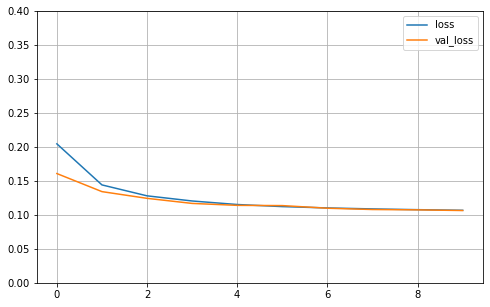

In [22]:
pd.DataFrame(stacked_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.4)
plt.show()

In [23]:
stacked_preds = stacked_auto.predict(X_test)


In [24]:
stacked_preds.shape

(3780, 28, 28)

In [59]:
stacked_auto.save_weights('stacked_auto.h5')

## Representations of digits in a lower dimensional space

In [ ]:
tsne = TSNE()
#use encoder to reduce dimensionality for TNSE
encoder_preds = stacked_encoder.predict(X_test)
X_test_2D = tsne.fit_transform(encoder_preds)

#generate legend labels
labels = np.unique(y_test).tolist()

#render the clusters of data in a 2 dimensional space
fig, ax = plt.subplots()

scatter = ax.scatter(X_test_2D[:, 0], X_test_2D[:,1], c=y_test, label=labels, s=10, cmap='turbo')
ax.set_xlim([-70, 80])
ax.legend(handles=scatter.legend_elements()[0], labels=labels)

In [25]:
tsne = TSNE()
encoder_preds = stacked_encoder.predict(X_test)
X_test_2D = tsne.fit_transform(encoder_preds)

In [26]:
labels = np.unique(y_test).tolist()

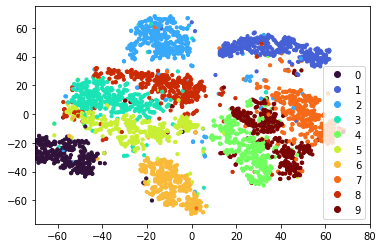

In [27]:
fig, ax = plt.subplots()

scatter = ax.scatter(X_test_2D[:, 0], X_test_2D[:,1], c=y_test, label=labels, s=10, cmap='turbo')
ax.set_xlim([-70, 80])
ax.legend(handles=scatter.legend_elements()[0], labels=labels)

# MNIST image autoencoder results

## Original image

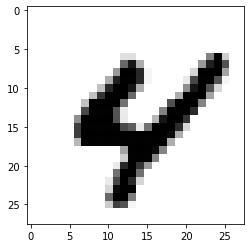

In [31]:
plt.imshow(X_test[12], cmap='gist_yarg')
plt.savefig('original.png', transparent=True)

## Convolutional Autoencoder Results

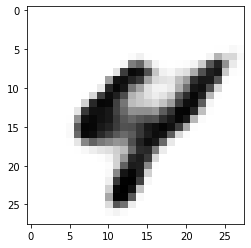

In [32]:
plt.imshow(preds[12], cmap='gist_yarg')
plt.savefig('Convolutional.png', transparent=True)

## Stacked Autoencoder Results

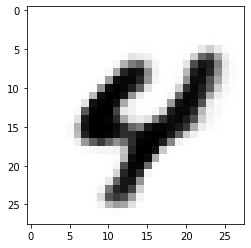

In [33]:
plt.imshow(stacked_preds[12], cmap='gist_yarg')
plt.savefig('Stacked.png', transparent=True)

In [54]:
Summary = {
    'Methodology': ['original','StackedAutoencoder', 'ConvolutionalAutoencoder'], 
    'TrainingDuration (s)': [0, round(stacked_duration, 2), round(convo_duration, 2)],
        }

df = pd.DataFrame.from_dict(Summary)

In [55]:
images = ['original.png', 'Stacked.png', 'Convolutional.png']

In [56]:
from IPython.display import Image, HTML
df['image'] = images

# convert your links to html tags 
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'

pd.set_option('display.max_colwidth', None)

display(HTML(df.to_html(escape=False ,formatters=dict(image=path_to_image_html))))

,Methodology,TrainingDuration (s),image
0,original,0.00,
1,StackedAutoencoder,21.95,
2,ConvolutionalAutoencoder,260.82,


# Trained model to make predictions

In [61]:
from keras.utils import to_categorical
#one hot encode our labels
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_val)

In [63]:
train_Y_one_hot.shape

(29400, 10)

In [65]:
train_Y_one_hot[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

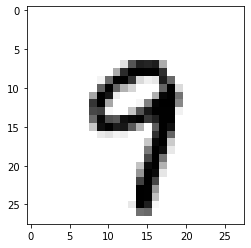

In [68]:
plt.imshow(X_train[1], cmap='binary')

In [92]:
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose

from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential

def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(10, activation='softmax')(den)
    return out

In [95]:
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose

from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential

def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    return conv3

def fc(enco):
    flat = Flatten()(enco)
    den = Dense(16, activation='relu')(flat)
    out = Dense(10, activation='softmax')(den)
    return out

In [96]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [97]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

ValueError: You called `set_weights(weights)` on layer "batch_normalization_53" with a weight list of length 0, but the layer was expecting 4 weights. Provided weights: []...